# How to use `sampler.py`

## Introduction
This notebook provides an example implementation of `sampler.py` to demonstrate its performance.

`sampler.py` contains multiple optimized functions that normalize a random portfolio to the index of 1 at the last observation using vector operations under the Numba library.

To demonstrate this implementation, we choose a random portfolio using a pre-processed dataset that includes the hourly volume-weighted average price (VWAP) for each cryptocurrency in Binance. To accomplish this task, we run the `get_train_batch` function that uses two other functions: `train_window` and `build_random_portfolios`.

## Dataset
The dataset used in this notebook is the Binance Portfolio Forecasting Hourly VWAP Dataset, which provides historical cryptocurrency price data from Binance. It includes data for 506 unique cryptocurrencies denominated in USD and has been pre-processed to calculate the hourly volume-weighted average price (VWAP) for each cryptocurrency. The dataset is useful for time series forecasting as VWAP is a more relevant indicator than just raw data points. The dataset has been pre-processed, including forward-filling missing data points to maintain the continuity of the time series and prevent any disruptions in downstream analysis.

## Functions
The train_batch and test_batch functions are provided to run the `get_train_batch` and `get_test_batch` functions, respectively, using specified hyperparameters.

## Performance Tests
To test the performance of the implementation, we run the functions for training data on 10 and 1000 samples and time the results.

## Visualization
Finally, we provide a visualization of the insample and outsample outputs for 10 random portfolios using the generated training data.


### Importing Libraries

In [1]:
# Importing all necessary libraries
import pickle
import pandas as pd
import numpy as np
import sys
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import numba
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import requests
import pickle

# Importing module from another folder
from sampler import get_train_batch, get_test_batch

# Remove warnings
import warnings
warnings.filterwarnings("ignore", category = DeprecationWarning)
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = NumbaPendingDeprecationWarning)

# Setting palette
sns.set(style="darkgrid", palette="Set2")

# Get the version of each library
print('pandas version: ', pd.__version__)
print('numpy version: ', np.__version__)
print('seaborn version: ', sns.__version__)
print('matplotlib version: ', matplotlib.__version__)
print('numba version: ', numba.__version__)
print('requests version: ', requests.__version__)

#print python version
print('python version: ', sys.version)
#print pickle version
print('pickle version: ', pickle.format_version)

pandas version:  1.4.4
numpy version:  1.22.4
seaborn version:  0.12.1
matplotlib version:  3.6.2
numba version:  0.55.2
requests version:  2.28.1
python version:  3.10.9 | packaged by conda-forge | (main, Feb  2 2023, 20:20:04) [GCC 11.3.0]
pickle version:  4.0


### Defining some functions

In [2]:
# Rewrite the train_batch function outside of the class
def train_batch(data, insample_size, outsample_size, batch_size):
    """
    A simple way to run the 'get_train_batch' function in sampler using the hyperparameters.

    Parameters
    ----------
    data : dictionary
        a dict with assets values
    insample_size : int
        the value for insample
    outsample_size : int
        the value for outsample
    batch_size :
        the size of the batch

    Returns
    -------
    array
        four array with values for x and y as well for the masks
    """
    # Get_train_batch for self.data
    return get_train_batch(data['dates'], data['dates_array'], data['train_cutoff'],
                             data['series'],
                             data['start_offsets'], data['finish_offsets'],
                             data['train_eligible'], data['compatibility'],
                             insample_size, outsample_size, batch_size)

# Test batch outside of the class
def test_batch(data, insample_size, outsample_size, batch_size):
    """
    A simple way to run the 'get_test_batch' function in sampler using the hyperparameters.

    Parameters
    ----------
    data : dictionary
        a dict with assets values
    insample_size : int
        the value for insample
    outsample_size : int
        the value for outsample
    batch_size :
        the size of the batch

    Returns
    -------
    array
        four array with values for x and y as well for the masks
    """
    # Get_test_batch for self.data
    return get_test_batch(data['dates'], data['dates_array'], data['train_cutoff'],
                             data['series'],
                             data['start_offsets'], data['finish_offsets'],
                             data['test_eligible'], data['compatibility'],
                             insample_size, outsample_size, batch_size)

### Loading the file

In [3]:
# URL of the file to download
file_url = 'https://osf.io/2pf93/download'

# send a GET request to the URL
response = requests.get(file_url)

# check if the request was successful (HTTP status code 200)
if response.status_code == 200:
    # open the file in binary write mode and write the response content to it
    with open('binance_dataset_original_20220112.pkl', 'wb') as f:
        f.write(response.content)

# load the downloaded data from the file
data = pickle.load(open('binance_dataset_original_20220112.pkl', 'rb'))

### Creating the training data

In [4]:
# Setting parameters for test batch
outsample_size = 48 #hours ahead 
lookbacks = 7 #horizons of outsample size 
batch_size = 10 
insample_size = lookbacks * outsample_size

# Running the function for training data
x, x_mask, y, y_mask = train_batch(data, insample_size, outsample_size, batch_size)

# Checking size of arrays
print('----------------')
print('Checking the size of generated arrays')
print('x size:', x.shape)
print('x_mask size:', x_mask.shape)
print('y size:', y.shape)
print('y_mask size:', y_mask.shape)

# Removing date column
x = x[:, :-3]

----------------
Checking the size of generated arrays
x size: (10, 339)
x_mask size: (10, 339)
y size: (10, 48)
y_mask size: (10, 48)


### Time efficiency for 1 batch of 10 series

In [5]:
%%timeit

# Running the function for training data
x, x_mask, y, y_mask = train_batch(data, insample_size, outsample_size, 10)

3.6 ms ± 115 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Time efficiency for 1 batch of 1000 series

In [6]:
%%timeit

# Running the function for training data
x, x_mask, y, y_mask = train_batch(data, insample_size, outsample_size, 1000)

48.5 ms ± 3.32 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Plotting the sampled portfolio series

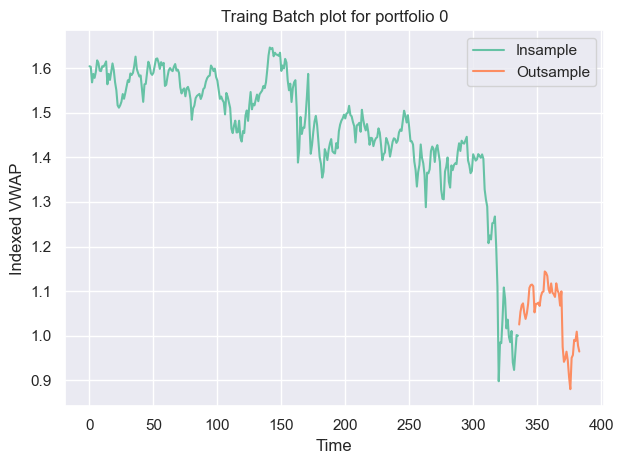

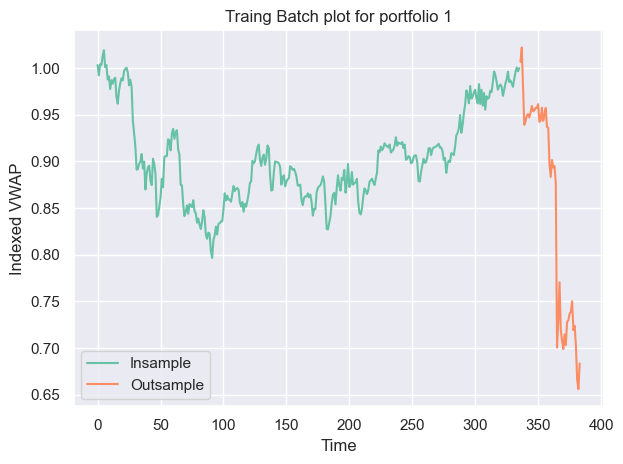

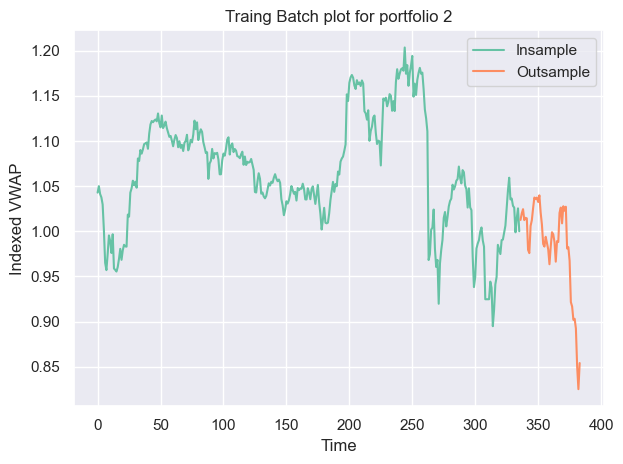

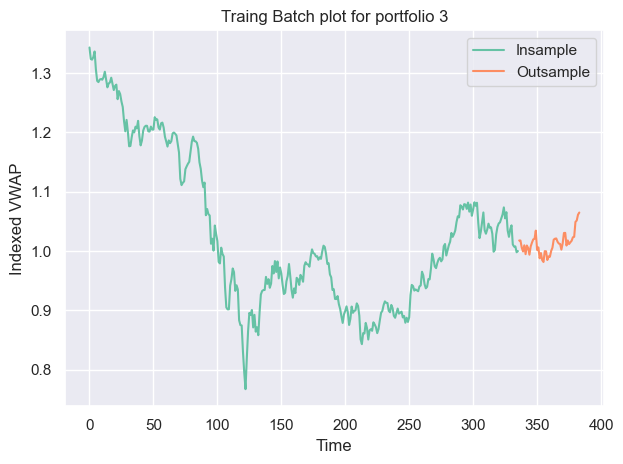

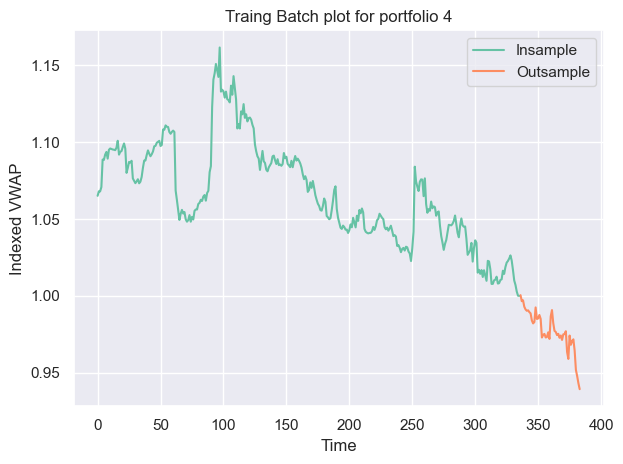

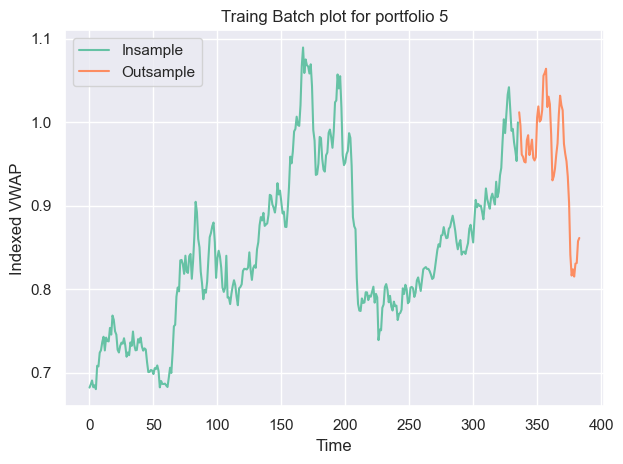

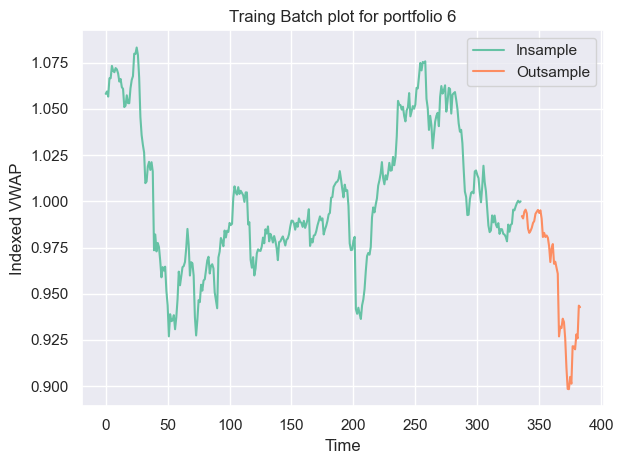

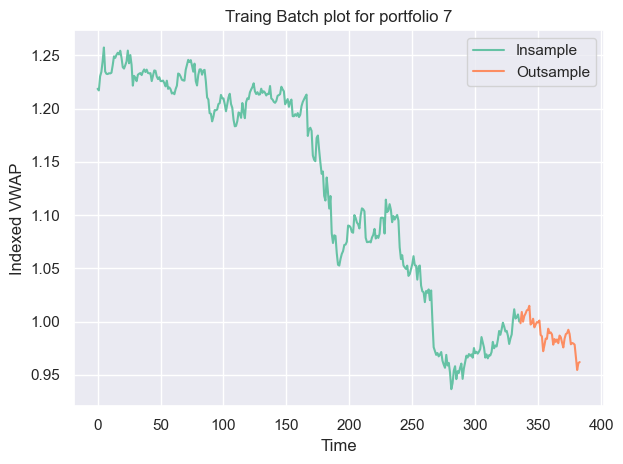

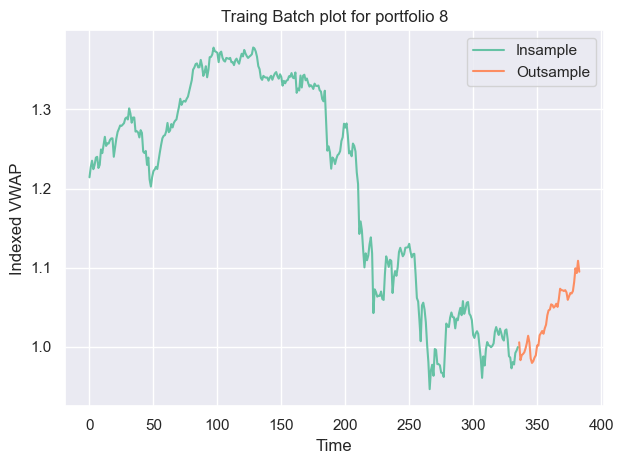

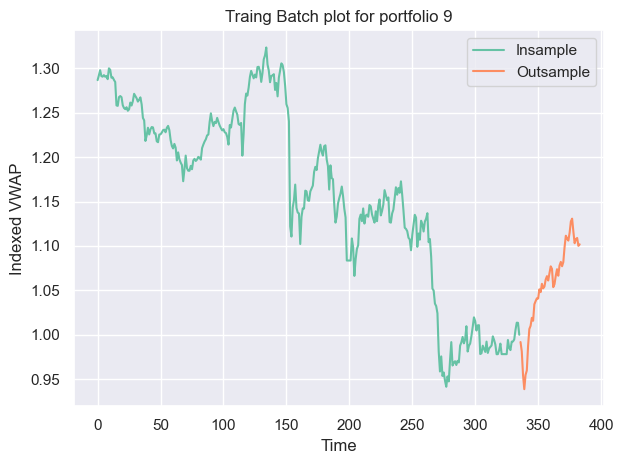

In [7]:
for i in range(10):
    plt.title('Traing Batch plot for portfolio {i}'.format(i=i))
    plt.plot(pd.DataFrame(x[i]), label='Insample')
    plt.plot(pd.DataFrame(y[i], index = np.arange(x.shape[1], x.shape[1] + 48)), label='Outsample')
    plt.xlabel('Time')
    plt.ylabel('Indexed VWAP')
    plt.legend()
    plt.tight_layout()
    plt.show()

    #if i=8 save the image with 300dpi
    if i == 8:
        plt.savefig('train_batch.png', dpi=300)

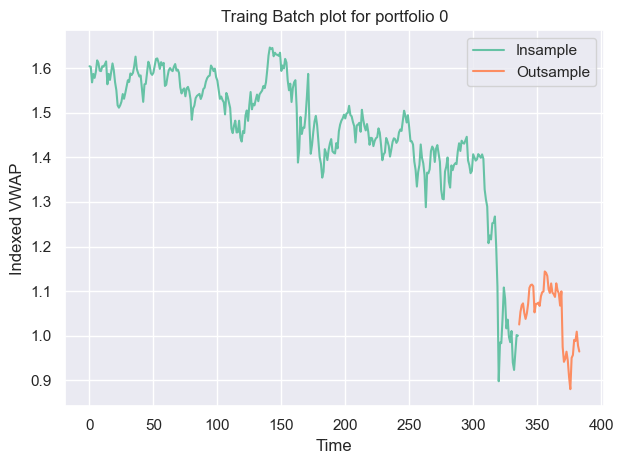

In [9]:
i=0
plt.title('Traing Batch plot for portfolio {i}'.format(i=i))
plt.plot(pd.DataFrame(x[i]), label='Insample')
plt.plot(pd.DataFrame(y[i], index = np.arange(x.shape[1], x.shape[1] + 48)), label='Outsample')
plt.xlabel('Time')
plt.ylabel('Indexed VWAP')
plt.legend()
plt.tight_layout()
# plt.show()
plt.savefig('train_batch.png', dpi=150)